In [27]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import gym
import torch
from matplotlib.ticker import PercentFormatter
from torch import nn
from gym import spaces
import random
from collections import deque
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch as th
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D,SimpleRNN,Bidirectional,Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,confusion_matrix
from stable_baselines3.common.callbacks import BaseCallback
from tensorflow.keras.layers import  Dropout, MultiHeadAttention,Input,LayerNormalization,GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

2.16.1


In [2]:
dataset = pd.read_csv('dataset/mbti_1.csv')

In [3]:
dataset.head(10)

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...
5  INTJ  '18/37 @.@|||Science  is not perfect. No scien...
6  INFJ  'No, I can't draw on my own nails (haha). Thos...
7  INTJ  'I tend to build up a collection of things on ...
8  INFJ  I'm not sure, that's a good question. The dist...
9  INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


C:\Users\PC\AppData\Local\Temp\ipykernel_11344\2227816498.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=mbti_counts.index, y=mbti_counts.values, palette='viridis')


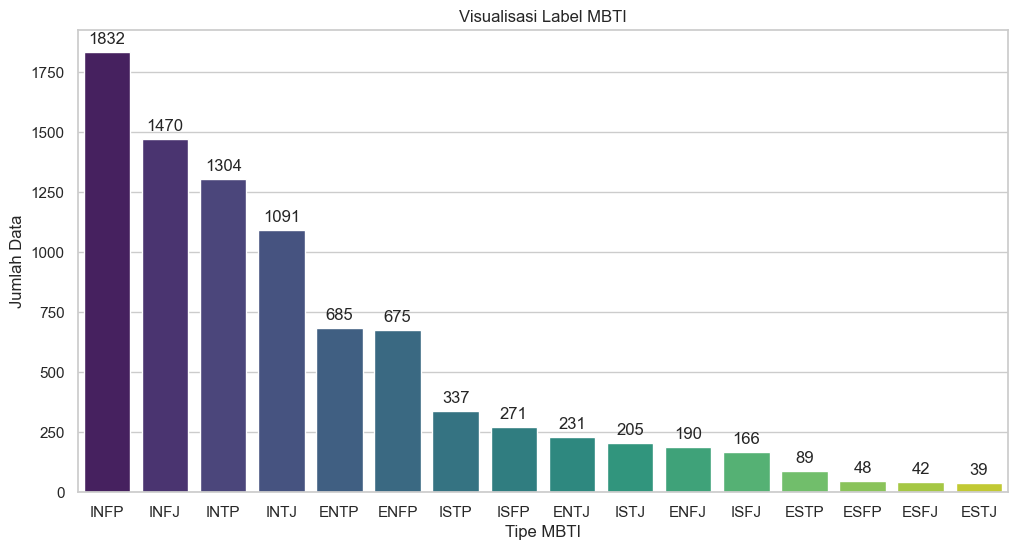

In [5]:
# Visualisasi labels MBTI
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))
mbti_counts = dataset['type'].value_counts()
bar_plot = sns.barplot(x=mbti_counts.index, y=mbti_counts.values, palette='viridis')

plt.title('Visualisasi Label MBTI')
plt.xlabel('Tipe MBTI')
plt.ylabel('Jumlah Data')

# Menambahkan angka di atas bar
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

plt.show()

In [6]:
# Inisialisasi dictionary untuk menyimpan jumlah setiap dikotomi
dichotomy_counts = {
    'I': 0, 'E': 0,
    'N': 0, 'S': 0,
    'T': 0, 'F': 0,
    'J': 0, 'P': 0
}

In [7]:
# Hitung jumlah untuk setiap dikotomi
for mbti_type, count in mbti_counts.items():
    dichotomy_counts[mbti_type[0]] += count  # I/E
    dichotomy_counts[mbti_type[1]] += count  # N/S
    dichotomy_counts[mbti_type[2]] += count  # T/F
    dichotomy_counts[mbti_type[3]] += count  # J/P

# Konversi hasil perhitungan ke DataFrame untuk visualisasi
dichotomy_df = pd.DataFrame(list(dichotomy_counts.items()), columns=['Dichotomy', 'Count'])


C:\Users\PC\AppData\Local\Temp\ipykernel_11344\2062065318.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot_dichotomy = sns.barplot(x='Dichotomy', y='Count', data=dichotomy_df, palette="viridis")


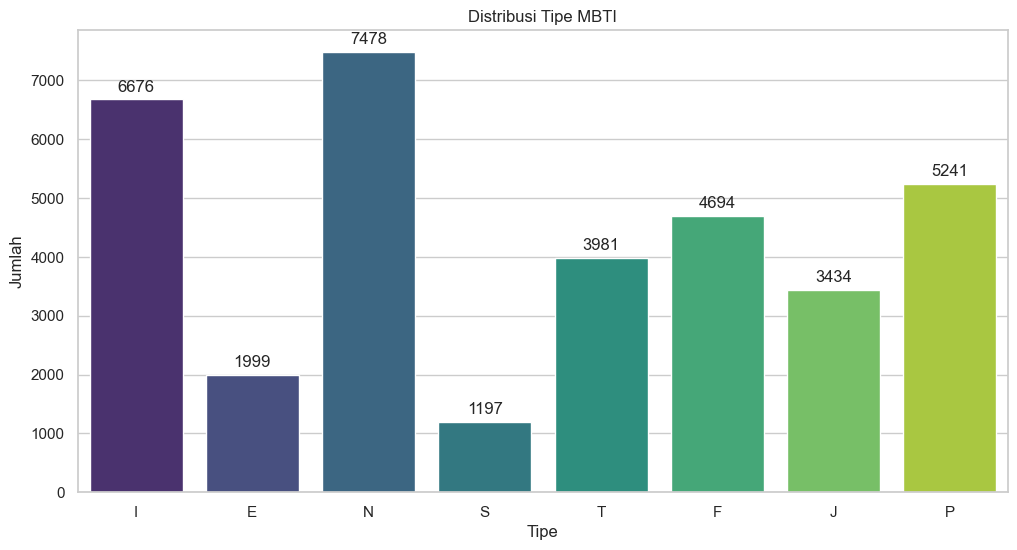

In [8]:
plt.figure(figsize=(12, 6))
bar_plot_dichotomy = sns.barplot(x='Dichotomy', y='Count', data=dichotomy_df, palette="viridis")
plt.title('Distribusi Tipe MBTI')
plt.xlabel('Tipe')
plt.ylabel('Jumlah')

# Menambahkan angka di atas bar
for p in bar_plot_dichotomy.patches:
    bar_plot_dichotomy.annotate(format(p.get_height(), '.0f'), 
                                (p.get_x() + p.get_width() / 2., p.get_height()), 
                                ha = 'center', va = 'center', 
                                xytext = (0, 9), 
                                textcoords = 'offset points')

plt.show()

In [9]:
# Fungsi Menghapus URL menggunakan regular expression
def hapus_url(text):
    return re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

# Fungsi Menghapus karakter non-alfabetik menggunakan regular expression
def hapus_nonalfabet(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Fungsi Mengonversi teks menjadi huruf kecil
def konversi_huruf_kecil(text):
    return text.lower()

# Fungsi Menghapus spasi 
def hapus_spasi(text):
    return ' '.join(text.split())

In [10]:
dataset_url = [hapus_url(post) for post in dataset['posts']]
dataset_nonalfabet = [hapus_nonalfabet(post) for post in dataset_url]
dataset_huruf_kecil = [konversi_huruf_kecil(post) for post in dataset_nonalfabet]
pembersihan_data = [hapus_spasi(post) for post in dataset_huruf_kecil]

In [11]:
# Menyimpan data setelah pembersihan
dataset['posts'] = pembersihan_data

In [12]:
dataset.head(10)

type                                              posts
0  INFJ  enfp and intj moments sportscenter not top ten...
1  ENTP  im finding the lack of me in these posts very ...
2  INTP  good one of course to which i say i know thats...
3  INTJ  dear intp i enjoyed our conversation the other...
4  ENTJ  youre firedthats another silly misconception t...
5  INTJ  science is not perfect no scientist claims tha...
6  INFJ  no i cant draw on my own nails haha those were...
7  INTJ  i tend to build up a collection of things on m...
8  INFJ  im not sure thats a good question the distinct...
9  INTP  im in this position where i have to actually l...

In [13]:
# Analisis Frekuensi kata
analisis_kata = CountVectorizer(stop_words='english')
X = analisis_kata.fit_transform(dataset['posts'])
kata_frekuensi = dict(zip(analisis_kata.get_feature_names_out(), X.sum(axis=0).A1))
kata_frekuensi_df = pd.DataFrame(list(kata_frekuensi.items()), columns=['kata', 'frekuensi']).sort_values(by='frekuensi', ascending=False)
kata_frekuensi_df.head(10)

kata  frekuensi
153704    like      67149
126200      im      65769
144219    just      52641
69708     dont      50999
269178   think      48648
199605  people      44118
147265    know      35686
218183  really      34032
273026    time      25534
141233     ive      24124

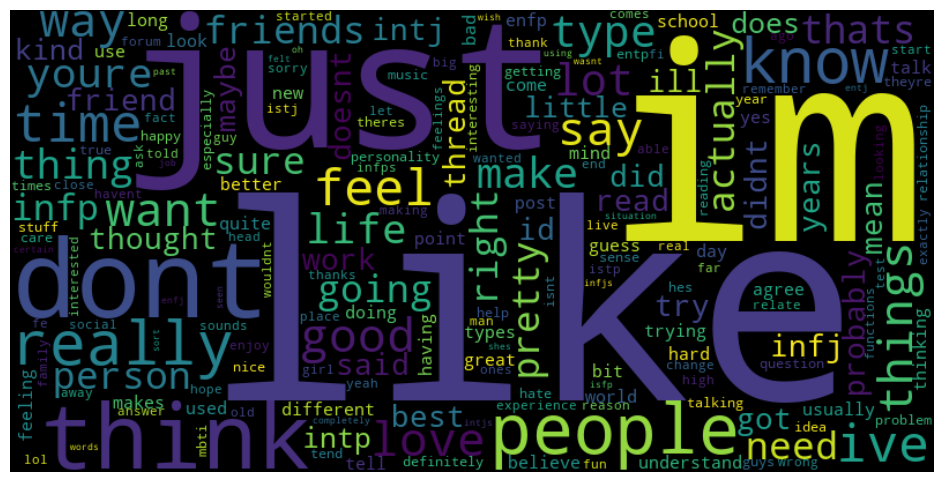

In [14]:
# Visualisasi Frekuensi kata
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(kata_frekuensi)
plt.figure(figsize=(20, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

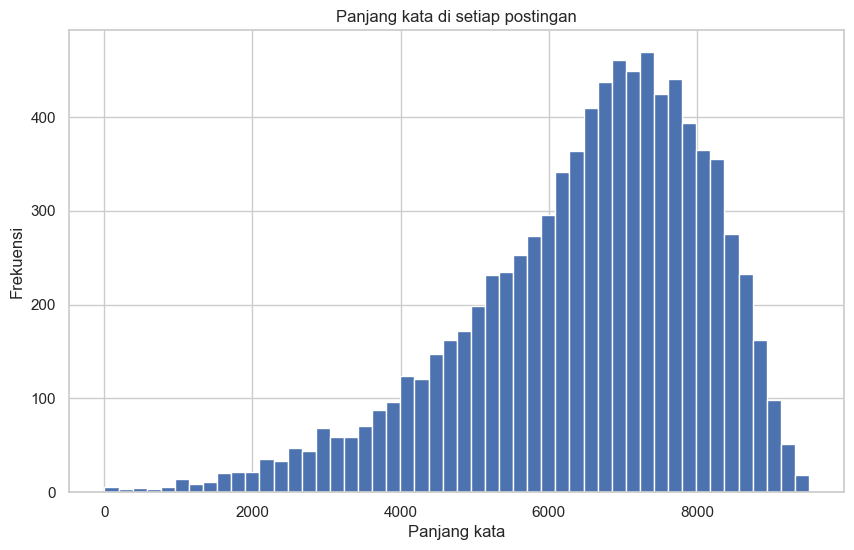

In [15]:
# Analisis panjangan kata
dataset['panjang_kata'] = dataset['posts'].apply(len)
plt.figure(figsize=(10, 6))
dataset['panjang_kata'].hist(bins=50)
plt.title('Panjang kata di setiap postingan')
plt.xlabel('Panjang kata')
plt.ylabel('Frekuensi')
plt.show()


In [16]:
dataset

type                                              posts  panjang_kata
0     INFJ  enfp and intj moments sportscenter not top ten...          3079
1     ENTP  im finding the lack of me in these posts very ...          5957
2     INTP  good one of course to which i say i know thats...          4548
3     INTJ  dear intp i enjoyed our conversation the other...          5667
4     ENTJ  youre firedthats another silly misconception t...          5322
...    ...                                                ...           ...
8670  ISFP  ixfp just because i always think of cats as fi...          4375
8671  ENFP  soif this thread already exists someplace else...          6992
8672  INTP  so many questions when i do these things i wou...          5137
8673  INFP  i am very conflicted right now when it comes t...          8783
8674  INFP  it has been too long since i have been on pers...          6763

[8675 rows x 3 columns]

In [17]:
texts = dataset['posts'].astype(str)
labels = dataset['type']

In [18]:
# Tokenisasi
tokenizer = Tokenizer(num_words=5000,lower=True)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [19]:
max_sequence_length = max(len(sequence) for sequence in sequences)

In [20]:
# Padding
X = pad_sequences(sequences, maxlen=500)

In [21]:
X

array([[   0,    0,    0, ...,  109,   14,  102],
       [  41,   39,  576, ...,    1,   15,    9],
       [  81,  175,  126, ...,    2,   20,  339],
       ...,
       [  90, 1222,   14, ...,   41,  257,  164],
       [  58,    2,   33, ...,   15, 1259,  190],
       [ 181,  176,    1, ...,   64,   14,   17]])

In [22]:
# Encoding labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

In [23]:
print(np.unique(y))
print("Jumlah label:", len(np.unique(y)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Jumlah label: 16


In [24]:
# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
print(y_test)

[11 10 11 ...  8 14 11]


# Model Deep Learning Dan Deep Reinforcement Learning

### 1. Models LSTM

In [25]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=100))
model_lstm.add(LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model_lstm.add(GlobalMaxPooling1D())
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(16, activation=None)) 
model_lstm.add(Dense(16, activation='softmax'))

# Callback untuk mengurangi learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Mengompile model_lstm
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Pelatihan model_lstm dengan callback
history_lstm= model_lstm.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=2, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
87/87 - 51s - 581ms/step - accuracy: 0.1727 - loss: 2.4727 - val_accuracy: 0.2219 - val_loss: 2.2920 - learning_rate: 0.0010
Epoch 2/20
87/87 - 41s - 468ms/step - accuracy: 0.2008 - loss: 2.3043 - val_accuracy: 0.2615 - val_loss: 2.2475 - learning_rate: 0.0010
Epoch 3/20
87/87 - 51s - 584ms/step - accuracy: 0.2558 - loss: 2.2422 - val_accuracy: 0.2666 - val_loss: 2.1846 - learning_rate: 0.0010
Epoch 4/20
87/87 - 49s - 563ms/step - accuracy: 0.3220 - loss: 2.1489 - val_accuracy: 0.3754 - val_loss: 2.0842 - learning_rate: 0.0010
Epoch 5/20
87/87 - 47s - 544ms/step - accuracy: 0.3862 - loss: 2.0462 - val_accuracy: 0.4020 - val_loss: 1.9747 - learning_rate: 0.0010
Epoch 6/20
87/87 - 43s - 498ms/step - accuracy: 0.4328 - loss: 1.9138 - val_accuracy: 0.4416 - val_loss: 1.8877 - learning_rate: 0.0010
Epoch 7/20
87/87 - 47s - 543ms/step - accuracy: 0.4737 - loss: 1.8091 - val_accuracy: 0.4654 - val_loss: 1.8280 - learning_rate: 0.0010
Epoch 8/20
87/87 - 49s - 562ms/step - accuracy: 

In [26]:
# Evaluasi model
score, acc = model_lstm.evaluate(X_test, y_test, verbose=2)
print(f'Test score: {score}, Test accuracy: {acc}')

55/55 - 5s - 96ms/step - accuracy: 0.4853 - loss: 1.7607
Test score: 1.7606537342071533, Test accuracy: 0.485302597284317


In [37]:
y_pred = model_lstm.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step


In [41]:
conf_metrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_metrix)

Confusion Matrix:
[[  0   6   0   3   0   0   0   0  11  17   2   2   0   0   0   0]
 [  0  55   0   9   0   0   0   0  15  30  12   4   0   0   0   0]
 [  0   2   0   8   0   0   0   0   7  12  10   5   0   0   0   0]
 [  0  10   0  59   0   0   0   0  10  28   8  20   0   0   0   0]
 [  0   1   0   0   0   0   0   0   2   3   0   1   0   0   0   0]
 [  0   2   0   2   0   0   0   0   1   1   1   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   3   4   0   0   0   0   0   0]
 [  0   0   0   3   0   0   0   0   3   7   1   1   0   0   0   0]
 [  0  10   0  11   0   0   0   0 167  59  21  20   0   0   0   0]
 [  0  18   0   6   0   0   0   0  35 270  19  22   0   0   0   0]
 [  0   7   0   6   0   0   0   0  24  27 110  19   0   0   0   0]
 [  0   6   0  14   0   0   0   0  25  48  19 181   0   0   0   0]
 [  0   2   0   3   0   0   0   0   8  20   8   4   0   0   0   0]
 [  0   3   0   2   0   0   0   0   5  31  10   2   0   0   0   0]
 [  0   8   0   1   0   0   0   0   5  23   

In [43]:
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(16)], zero_division=0)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        41
     Class 1       0.40      0.44      0.42       125
     Class 2       0.00      0.00      0.00        44
     Class 3       0.45      0.44      0.44       135
     Class 4       0.00      0.00      0.00         7
     Class 5       0.00      0.00      0.00         8
     Class 6       0.00      0.00      0.00         7
     Class 7       0.00      0.00      0.00        15
     Class 8       0.50      0.58      0.54       288
     Class 9       0.45      0.73      0.55       370
    Class 10       0.48      0.57      0.52       193
    Class 11       0.60      0.62      0.61       293
    Class 12       0.00      0.00      0.00        45
    Class 13       0.00      0.00      0.00        53
    Class 14       0.00      0.00      0.00        44
    Class 15       0.00      0.00      0.00        67

    accuracy                           0.49      1735
   

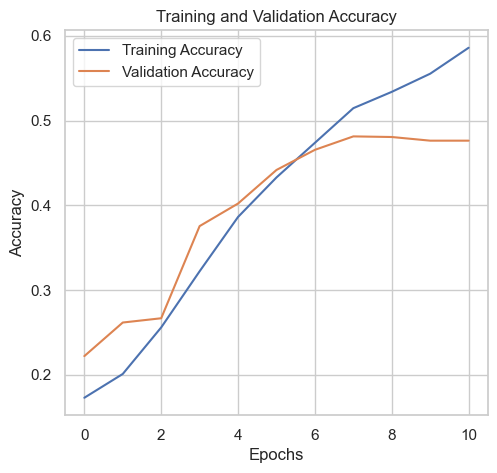

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model Q-learning

In [51]:
class MBTIEnvironment(gym.Env):
    """Custom environment untuk menggunakan output LSTM sebagai state dalam Q-learning."""
    def __init__(self, model_lstm, X_data):
        super(MBTIEnvironment, self).__init__()
        self.model_lstm = model_lstm
        self.X_data = X_data
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(16,), dtype=np.float32) 

    def reset(self):
        random_index = np.random.randint(0, len(self.X_data))
        input_data = self.X_data[random_index:random_index+1]
        prediction = self.model_lstm.predict(input_data)
        self.state = np.argmax(prediction)
        return self.state

    def step(self, action):
        random_index = np.random.randint(0, len(self.X_data))
        input_data = self.X_data[random_index:random_index+1]
        prediction = self.model_lstm.predict(input_data)
        self.state = np.argmax(prediction)
        reward = np.random.rand()  
        done = np.random.choice([True, False], p=[0.1, 0.9])
        info = {}
        return self.state, reward, done, info

    def render(self, mode='human'):
        pass

    def close(self):
        pass

In [52]:
def train_q_learning(env, episodes, alpha, gamma, epsilon):
    q_table = np.zeros((env.observation_space.shape[0], env.action_space.n))
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            
            next_state, reward, done, info = env.step(action)
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])
            
            q_table[state, action] = old_value + alpha * (reward + gamma * next_max - old_value)
            state = next_state
    
    return q_table

In [53]:
# Parameter
alpha = 0.1
gamma = 0.9 
epsilon = 0.1 
episodes = 100

In [54]:
env = MBTIEnvironment(model_lstm, X)

In [55]:
q_table_trained = train_q_learning(env, episodes, alpha, gamma, epsilon)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━

In [56]:
def evaluate_policy(env, q_table, episodes):
    rewards_per_episode_Q_learning = [] 

    for _ in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0  

        while not done:
            action = np.argmax(q_table[state]) 
            state, reward, done, info = env.step(action)
            total_reward += reward

        rewards_per_episode_Q_learning.append(total_reward)  

    average_reward = np.mean(rewards_per_episode_Q_learning)  
    return average_reward, rewards_per_episode_Q_learning

In [57]:
average_reward, rewards_per_episode_Q_learning = evaluate_policy(env, q_table_trained, 100)
print("Rata-rata Reward:", average_reward)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━

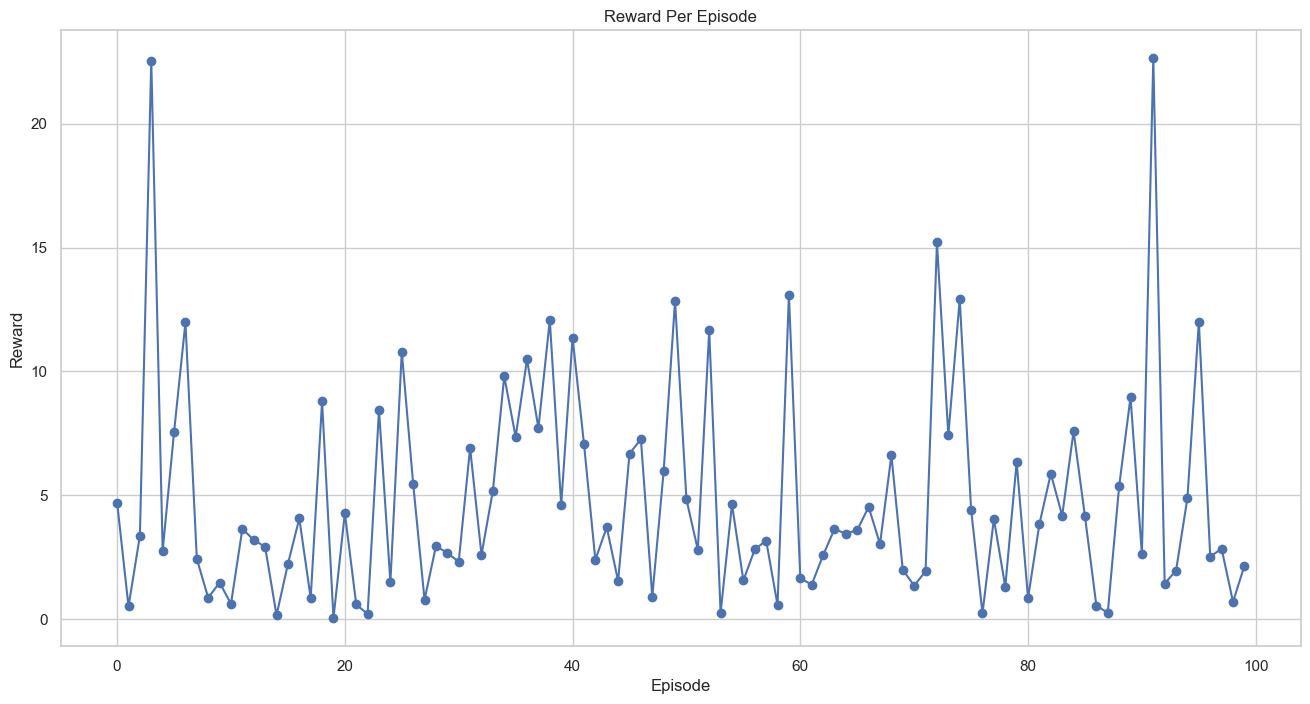

In [58]:
plt.figure(figsize=(16, 8))
plt.plot(rewards_per_episode_Q_learning, marker='o', linestyle='-', color='b')
plt.title('Reward Per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

<Figure size 1000x500 with 0 Axes>

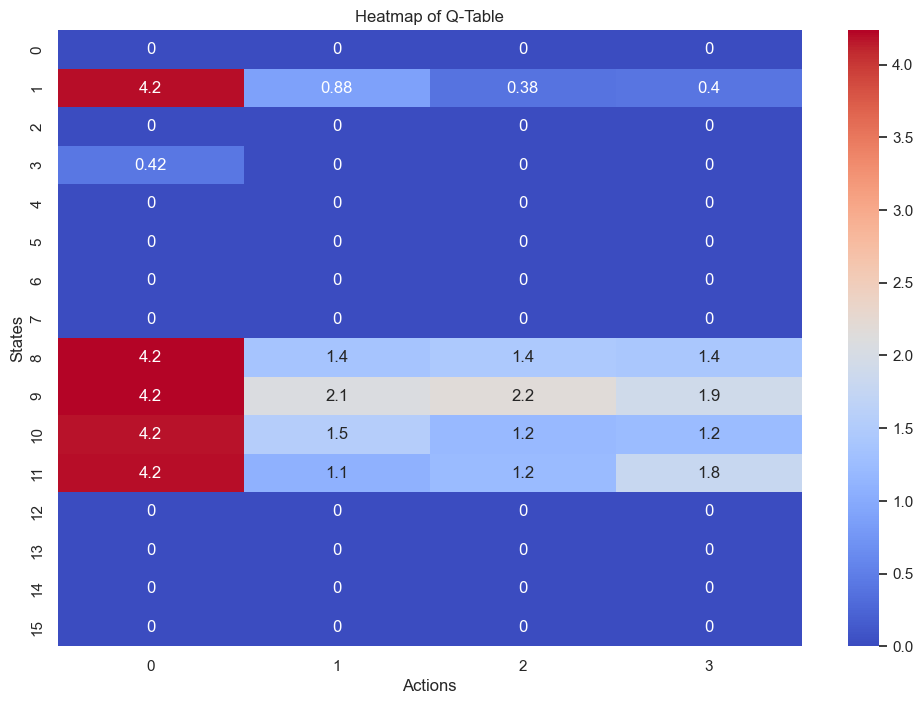

In [59]:
plt.figure(figsize=(10, 5))
plt.figure(figsize=(12, 8))
sns.heatmap(q_table_trained, annot=True, cmap="coolwarm")
plt.title('Heatmap of Q-Table')
plt.xlabel('Actions')
plt.ylabel('States')
plt.show()

### 2. Model CNN

In [45]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=5000, output_dim=100))
model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn.add(Dense(16, activation='softmax'))

model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history_cnn = model_cnn.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - accuracy: 0.1563 - loss: 2.8000 - val_accuracy: 0.2282 - val_loss: 2.4076
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 0.2764 - loss: 2.3419 - val_accuracy: 0.3510 - val_loss: 2.1696
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.3781 - loss: 2.1228 - val_accuracy: 0.4357 - val_loss: 1.9977
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 0.4136 - loss: 2.0085 - val_accuracy: 0.4669 - val_loss: 1.8963
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.4580 - loss: 1.8888 - val_accuracy: 0.4928 - val_loss: 1.8085
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.5037 - loss: 1.7647 - val_accuracy: 0.5170 - val_loss: 1.7489
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.5575 - loss: 1.6199 - val_accuracy: 0.5199 - val_loss: 1.7137
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.6080 - loss: 1

In [46]:
# Evaluasi model
score, acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print(f'Test score: {score}, Test accuracy: {acc}')

55/55 - 1s - 26ms/step - accuracy: 0.5199 - loss: 1.7137
Test score: 1.7136961221694946, Test accuracy: 0.5198847055435181


In [47]:
y_pred = model_cnn.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [49]:
conf_metrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_metrix)

Confusion Matrix:
[[  0   5   0   5   0   0   0   0  12  11   3   5   0   0   0   0]
 [  0  62   0   9   0   0   0   0  20  19   9   6   0   0   0   0]
 [  0   2   0   7   0   0   0   0   3  10  17   5   0   0   0   0]
 [  0   5   0  81   0   0   0   0  10  18   7  14   0   0   0   0]
 [  0   0   0   1   0   0   0   0   3   1   0   2   0   0   0   0]
 [  0   2   0   2   0   0   0   0   1   1   2   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   1   4   1   0   0   0   0   0]
 [  0   1   0   3   0   0   0   0   2   5   1   3   0   0   0   0]
 [  0   5   0  15   0   0   0   0 193  40  17  18   0   0   0   0]
 [  0   9   0   9   0   0   0   0  49 268  14  21   0   0   0   0]
 [  0   3   0  12   0   0   0   0  23  23 114  18   0   0   0   0]
 [  0   3   0  19   0   0   0   0  29  43  15 184   0   0   0   0]
 [  0   4   0   5   0   0   0   0   9  13   7   7   0   0   0   0]
 [  0   2   0   2   0   0   0   0   5  19   8  17   0   0   0   0]
 [  0   6   0   3   0   0   0   0  10  13   

In [50]:
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(16)], zero_division=0)
print("classification_report")
print(report)

classification_report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        41
     Class 1       0.55      0.50      0.52       125
     Class 2       0.00      0.00      0.00        44
     Class 3       0.45      0.60      0.51       135
     Class 4       0.00      0.00      0.00         7
     Class 5       0.00      0.00      0.00         8
     Class 6       0.00      0.00      0.00         7
     Class 7       0.00      0.00      0.00        15
     Class 8       0.52      0.67      0.58       288
     Class 9       0.54      0.72      0.62       370
    Class 10       0.51      0.59      0.55       193
    Class 11       0.53      0.63      0.57       293
    Class 12       0.00      0.00      0.00        45
    Class 13       0.00      0.00      0.00        53
    Class 14       0.00      0.00      0.00        44
    Class 15       0.00      0.00      0.00        67

    accuracy                           0.52      1735
   m

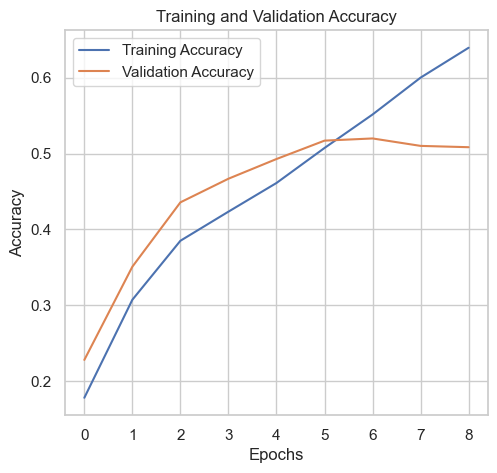

In [51]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### model Q-nertwork

In [60]:
class CNNMBTIEnvironment(gym.Env):
    def __init__(self, model, X_data, step_limit=50):
        super(CNNMBTIEnvironment, self).__init__()
        self.model = model
        self.X_data = X_data
        self.step_limit = step_limit
        self.action_space = spaces.Discrete(16)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(100,), dtype=np.float32)

    def reset(self):
        self.current_index = np.random.randint(0, len(self.X_data))
        self.state = self.X_data[self.current_index:self.current_index+1]
        self.step_count = 0
        return self.state

    def step(self, action):
        self.step_count += 1
        probs = self.model.predict(self.state)
        predicted_action = np.argmax(probs)
        reward = 1 if action == predicted_action else 0
        self.current_index = np.random.randint(0, len(self.X_data))
        self.state = self.X_data[self.current_index:self.current_index+1]
        done = self.step_count >= self.step_limit  # Episode ends after a certain number of steps
        info = {'probabilities': probs.flatten(), 'predicted_action': predicted_action}
        return self.state, reward, done, info

    def render(self, mode='human'):
        pass

    def close(self):
        pass


In [61]:
# Fungsi untuk membuat Q-Network
def create_q_network(input_dim, output_dim):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=100))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(output_dim, activation='linear'))

    model.compile(loss='mse', optimizer='adam')
    return model


In [62]:
input_dim = 5000 
action_dim = 16  
q_network = create_q_network(input_dim, action_dim)

In [63]:
env = CNNMBTIEnvironment(q_network, X_train)

In [64]:
def epsilon_greedy_policy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(0, action_dim)
    else:
        q_values = q_network.predict(state)
        return np.argmax(q_values)

In [65]:
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episodes = 100
rewards_per_episode_Q_nertwork = [] 
epsilons = []

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    
    while True:
        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        
        target_q = reward + 0.99 * np.max(q_network.predict(next_state))
        current_q = q_network.predict(state)
        current_q[0][action] = target_q

        q_network.fit(state, current_q, epochs=1, verbose=0)
        
        state = next_state
        
        if done:
            epsilon = max(epsilon_min, epsilon * epsilon_decay)
            rewards_per_episode_Q_nertwork.append(total_reward)
            epsilons.append(epsilon)
            print(f'Episode: {episode+1}, Total reward: {total_reward}, Epsilon: {epsilon:.2f}')
            break

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━

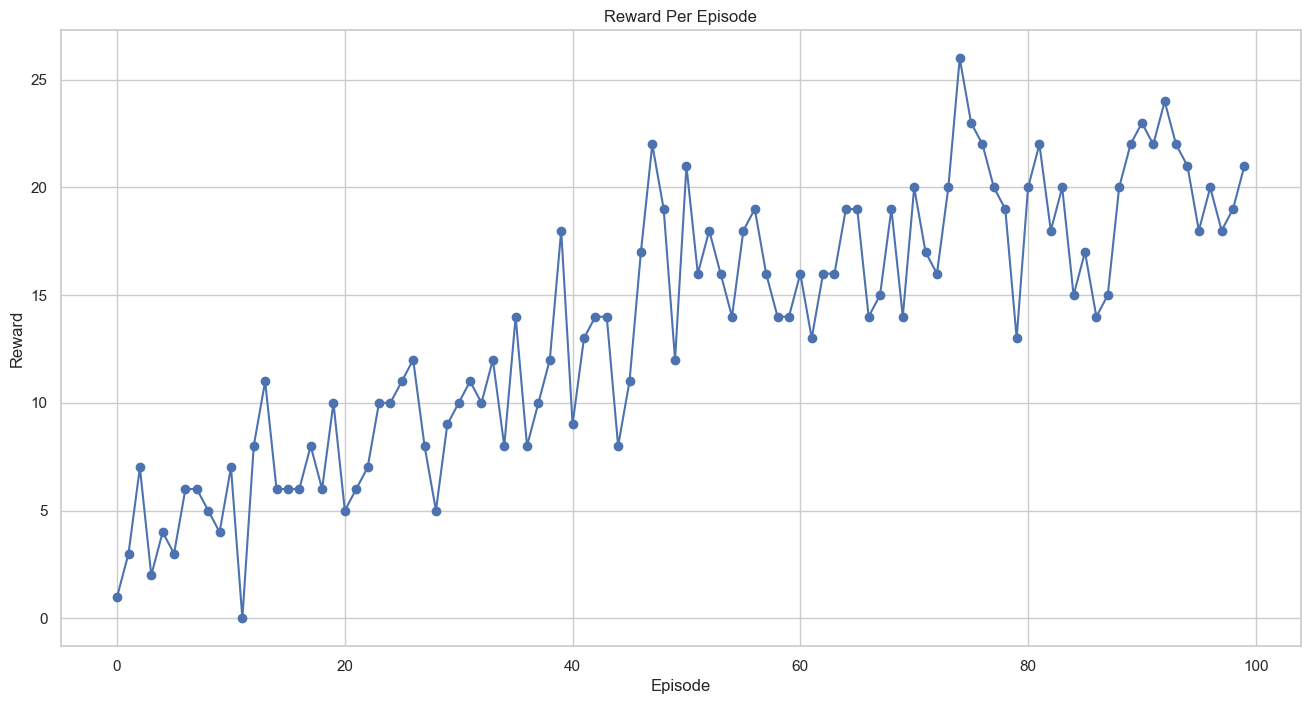

In [66]:
# Visualisasi Total Reward per Episode
plt.figure(figsize=(16, 8))
plt.plot(rewards_per_episode_Q_nertwork , marker='o', linestyle='-', color='b')
plt.title('Reward Per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()
# Total Reward per Episode: Menunjukkan bagaimana total reward yang diperoleh oleh agen berubah selama pelatihan.

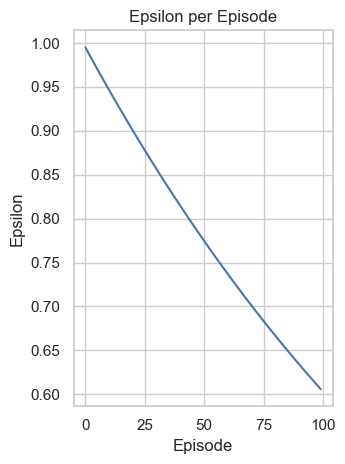

In [67]:
plt.subplot(1, 2, 2)
plt.plot(epsilons)
plt.title('Epsilon per Episode')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

plt.tight_layout()
plt.show()
# Epsilon per Episode: Menunjukkan bagaimana nilai epsilon (tingkat eksplorasi) berkurang dari waktu ke waktu, menunjukkan transisi dari eksplorasi ke eksploitasi.

### 3. Model RNN

In [52]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100))
model.add(SpatialDropout1D(0.3))
model.add(SimpleRNN(150, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(16, activation='softmax', kernel_regularizer=l2(0.01)))

# Callback untuk mengurangi learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Mengompile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Pelatihan model dengan callback
history_rnn = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=2, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
87/87 - 25s - 286ms/step - accuracy: 0.0767 - loss: 3.1192 - val_accuracy: 0.1362 - val_loss: 2.9261 - learning_rate: 0.0010
Epoch 2/20
87/87 - 22s - 250ms/step - accuracy: 0.1128 - loss: 2.8778 - val_accuracy: 0.1455 - val_loss: 2.7377 - learning_rate: 0.0010
Epoch 3/20
87/87 - 23s - 262ms/step - accuracy: 0.1315 - loss: 2.7584 - val_accuracy: 0.1073 - val_loss: 2.7257 - learning_rate: 0.0010
Epoch 4/20
87/87 - 21s - 241ms/step - accuracy: 0.1589 - loss: 2.6667 - val_accuracy: 0.1607 - val_loss: 2.5985 - learning_rate: 0.0010
Epoch 5/20
87/87 - 19s - 217ms/step - accuracy: 0.1497 - loss: 2.6057 - val_accuracy: 0.1952 - val_loss: 2.5598 - learning_rate: 0.0010
Epoch 6/20
87/87 - 21s - 237ms/step - accuracy: 0.1592 - loss: 2.5619 - val_accuracy: 0.1520 - val_loss: 2.5524 - learning_rate: 0.0010
Epoch 7/20
87/87 - 19s - 224ms/step - accuracy: 0.1733 - loss: 2.5092 - val_accuracy: 0.1758 - val_loss: 2.4924 - learning_rate: 0.0010
Epoch 8/20
87/87 - 19s - 215ms/step - accuracy: 

In [53]:
# Evaluasi model
score, acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test score: {score}, Test accuracy: {acc}')

55/55 - 2s - 44ms/step - accuracy: 0.2144 - loss: 2.3222
Test score: 2.322160243988037, Test accuracy: 0.2144092172384262


In [54]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


In [55]:
conf_metrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_metrix)

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   2  39   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   2 123   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1  43   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   2 133   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   7   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   8   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   7   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1  14   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   8 280   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   6 364   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   2 191   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   6 287   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   2  43   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   3  50   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  44   

In [56]:
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(16)], zero_division=0)
print("classification_report")
print(report)

classification_report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        41
     Class 1       0.00      0.00      0.00       125
     Class 2       0.00      0.00      0.00        44
     Class 3       0.00      0.00      0.00       135
     Class 4       0.00      0.00      0.00         7
     Class 5       0.00      0.00      0.00         8
     Class 6       0.00      0.00      0.00         7
     Class 7       0.00      0.00      0.00        15
     Class 8       0.22      0.03      0.05       288
     Class 9       0.21      0.98      0.35       370
    Class 10       0.00      0.00      0.00       193
    Class 11       0.00      0.00      0.00       293
    Class 12       0.00      0.00      0.00        45
    Class 13       0.00      0.00      0.00        53
    Class 14       0.00      0.00      0.00        44
    Class 15       0.00      0.00      0.00        67

    accuracy                           0.21      1735
   m

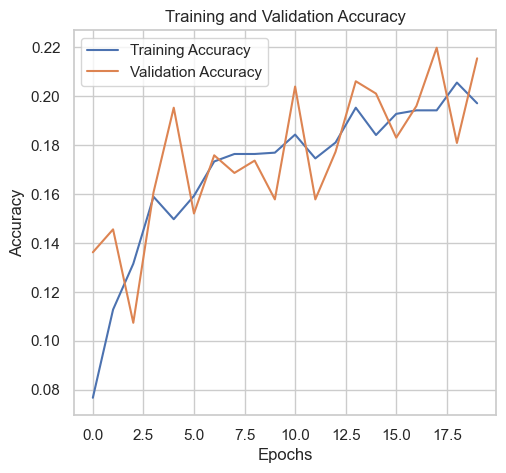

In [57]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Policy Gradient Methods

In [68]:
class RNNEnvironment(gym.Env):    
    def __init__(self, model_rnn, X_data):
        super(RNNEnvironment, self).__init__()
        self.model_rnn = model_rnn
        self.X_data = X_data
        self.action_space = spaces.Discrete(16)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(16,), dtype=np.float32)

    def reset(self):
        random_index = np.random.randint(0, len(self.X_data))
        input_data = self.X_data[random_index:random_index + 1]
        prediction = self.model_rnn.predict(input_data)
        self.state = prediction[0]
        return self.state

    def step(self, action):
        random_index = np.random.randint(0, len(self.X_data))
        input_data = self.X_data[random_index:random_index + 1]
        prediction = self.model_rnn.predict(input_data)
        self.state = prediction[0]
        
        reward = self.calculate_reward(action)
        done = self.is_done()
        info = {}
        return self.state, reward, done, info

    def calculate_reward(self, action):
        return np.random.rand()

    def is_done(self):
        return np.random.choice([True, False], p=[0.1, 0.9])

In [69]:
env = RNNEnvironment(model, X_train)

In [70]:
# Fungsi untuk membangun model policy
def build_policy_model(env, learning_rate=0.01):
    model = models.Sequential([
        layers.Input(shape=(env.observation_space.shape[0],)),
        layers.Dense(24, activation='relu'),
        layers.Dense(env.action_space.n, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    return model, optimizer

In [71]:
def get_action(state, model, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        state = state.reshape([1, -1])
        action_probs = model.predict(state)
        return np.argmax(action_probs)

In [72]:
# Fungsi untuk menghitung return dengan diskon
def compute_returns(rewards, gamma):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return np.array(returns)

In [73]:
# Fungsi training policy gradient
def train_policy_gradient(env, episodes, alpha, gamma, epsilon_start, epsilon_decay, epsilon_min):
    model_policy, optimizer = build_policy_model(env, learning_rate=alpha)
    epsilon = epsilon_start
    rewards_per_episode_policy_gradient_methode = []
    epsilons = []

    for episode in range(episodes):
        epsilons.append(epsilon)
        state = env.reset()
        done = False
        rewards = []
        states = []
        actions = []
        total_reward = 0

        while not done:
            action = get_action(state, model_policy, epsilon)
            next_state, reward, done, _ = env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            total_reward += reward
        
        rewards_per_episode_policy_gradient_methode.append(total_reward)
        returns = compute_returns(rewards, gamma)
        returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-10)

        with tf.GradientTape() as tape:
            loss = 0
            for idx, (state, action, Gt) in enumerate(zip(states, actions, returns)):
                state = state.reshape([1, -1])
                probs = model_policy(state, training=True)
                action_probs = probs[0, action]
                loss += -tf.math.log(action_probs) * Gt
        
        grads = tape.gradient(loss, model_policy.trainable_variables)
        optimizer.apply_gradients(zip(grads, model_policy.trainable_variables))
        
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        if episode % 50 == 0:
            print(f"Episode {episode}/{episodes} completed, Average Reward: {np.mean(rewards_per_episode_policy_gradient_methode[-50:])}")

    return rewards_per_episode_policy_gradient_methode, epsilons 

In [74]:
rewards_per_episode_policy_gradient_methode , epsilons=train_policy_gradient(env, episodes=100, alpha=0.01, gamma=0.9, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Episode 0/100 completed, Average Reward: 0.6400828991929137
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [75]:
def plot_episode_rewards(episode_rewards):
    plt.figure(figsize=(16, 8))
    plt.plot(episode_rewards, marker='o', linestyle='-', color='b')
    plt.title('Reward Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()

In [76]:
def plot_epsilons(epsilons):
    plt.figure(figsize=(12, 6))
    plt.plot(epsilons, label='Epsilon Value per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay Over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

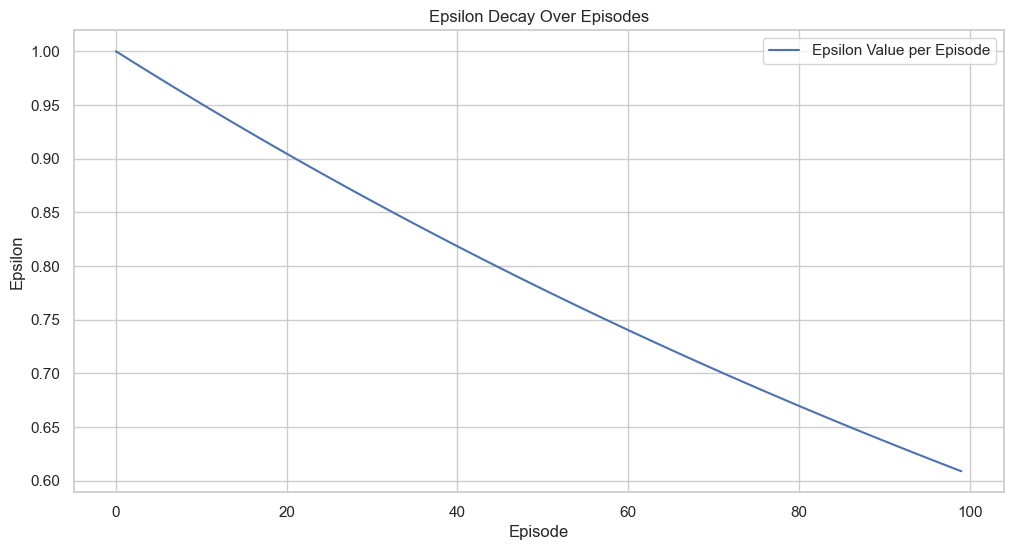

In [77]:
# Epsilon per Episode: Menunjukkan bagaimana nilai epsilon (tingkat eksplorasi) berkurang dari waktu ke waktu, menunjukkan transisi dari eksplorasi ke eksploitasi.
plot_epsilons(epsilons)

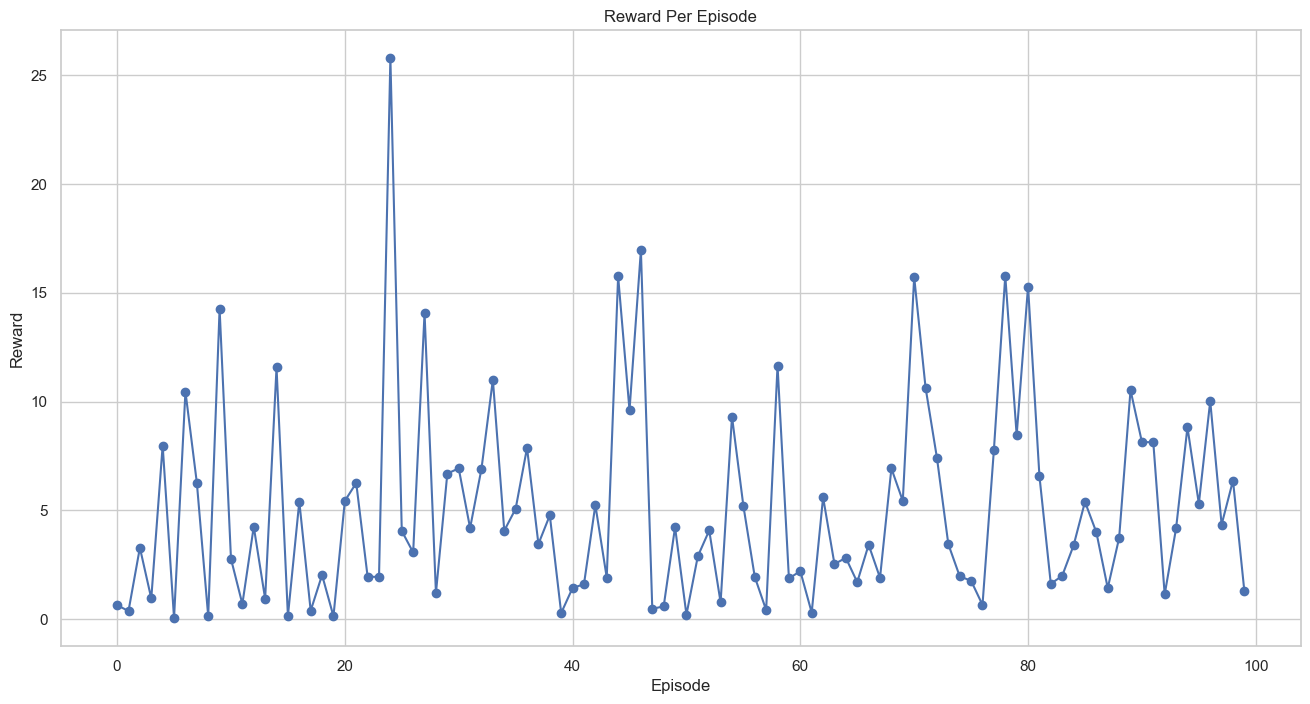

In [78]:
# Total Reward per Episode: Menunjukkan bagaimana total reward yang diperoleh oleh agen berubah selama pelatihan.
plot_episode_rewards(rewards_per_episode_policy_gradient_methode)

## 4. Model BILSTM

In [75]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100))
Bidirectional(LSTM(150, dropout=0.3, recurrent_dropout=0.3,return_sequences=True))
Bidirectional(LSTM(100))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu')) 
model.add(Dense(16, activation='softmax'))

# Callback untuk mengurangi learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Mengompile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Pelatihan model dengan callback
history_bilstm = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=2, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
87/87 - 4s - 42ms/step - accuracy: 0.1697 - loss: 2.5158 - val_accuracy: 0.2219 - val_loss: 2.3153 - learning_rate: 0.0010
Epoch 2/20
87/87 - 2s - 28ms/step - accuracy: 0.2012 - loss: 2.2966 - val_accuracy: 0.2219 - val_loss: 2.2832 - learning_rate: 0.0010
Epoch 3/20
87/87 - 2s - 26ms/step - accuracy: 0.2026 - loss: 2.2799 - val_accuracy: 0.2219 - val_loss: 2.2635 - learning_rate: 0.0010
Epoch 4/20
87/87 - 2s - 26ms/step - accuracy: 0.2179 - loss: 2.2564 - val_accuracy: 0.2514 - val_loss: 2.2365 - learning_rate: 0.0010
Epoch 5/20
87/87 - 2s - 28ms/step - accuracy: 0.2592 - loss: 2.2121 - val_accuracy: 0.2824 - val_loss: 2.1890 - learning_rate: 0.0010
Epoch 6/20
87/87 - 2s - 24ms/step - accuracy: 0.2878 - loss: 2.1604 - val_accuracy: 0.3256 - val_loss: 2.1295 - learning_rate: 0.0010
Epoch 7/20
87/87 - 2s - 23ms/step - accuracy: 0.3179 - loss: 2.1058 - val_accuracy: 0.3545 - val_loss: 2.0636 - learning_rate: 0.0010
Epoch 8/20
87/87 - 2s - 23ms/step - accuracy: 0.3381 - loss: 2

In [80]:
# Evaluasi model
score, acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test score: {score}, Test accuracy: {acc}')

55/55 - 0s - 3ms/step - accuracy: 0.4830 - loss: 1.7639
Test score: 1.7638671398162842, Test accuracy: 0.4829971194267273


In [81]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [82]:
conf_metrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_metrix)

Confusion Matrix:
[[  0   2   0   1   0   0   0   0  16  15   2   3   0   0   0   2]
 [  0  31   0  16   0   0   0   0  24  33  12   3   0   0   0   6]
 [  0   0   0   7   0   0   0   0   7  13  10   5   0   0   0   2]
 [  0   2   0  77   0   0   0   0  15  19   7  14   0   0   0   1]
 [  0   0   0   1   0   0   0   0   2   3   0   1   0   0   0   0]
 [  0   1   0   2   0   0   0   0   2   0   1   1   0   0   0   1]
 [  0   0   0   1   0   0   0   0   1   3   0   1   0   0   0   1]
 [  0   0   0   2   0   0   0   0   2   5   3   1   0   1   0   1]
 [  0   6   0  14   0   0   0   0 178  61  13  12   0   1   0   3]
 [  0   3   0   9   0   0   0   0  47 265  21  21   0   1   0   3]
 [  0   1   0  11   0   0   0   0  24  38  89  23   0   2   0   5]
 [  0   0   0  25   0   0   0   0  23  56  24 160   0   2   0   3]
 [  0   1   0   3   0   0   0   0   8  17   5   4   0   0   0   7]
 [  0   0   0   3   0   0   0   0   7  29   7   3   0   4   0   0]
 [  0   0   0   2   0   0   0   0   6  16   

In [83]:
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(16)], zero_division=0)
print("classification_report")
print(report)

classification_report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        41
     Class 1       0.63      0.25      0.36       125
     Class 2       0.00      0.00      0.00        44
     Class 3       0.44      0.57      0.50       135
     Class 4       0.00      0.00      0.00         7
     Class 5       0.00      0.00      0.00         8
     Class 6       0.00      0.00      0.00         7
     Class 7       0.00      0.00      0.00        15
     Class 8       0.48      0.62      0.54       288
     Class 9       0.46      0.72      0.56       370
    Class 10       0.43      0.46      0.44       193
    Class 11       0.59      0.55      0.57       293
    Class 12       0.00      0.00      0.00        45
    Class 13       0.33      0.08      0.12        53
    Class 14       0.00      0.00      0.00        44
    Class 15       0.46      0.51      0.48        67

    accuracy                           0.48      1735
   m

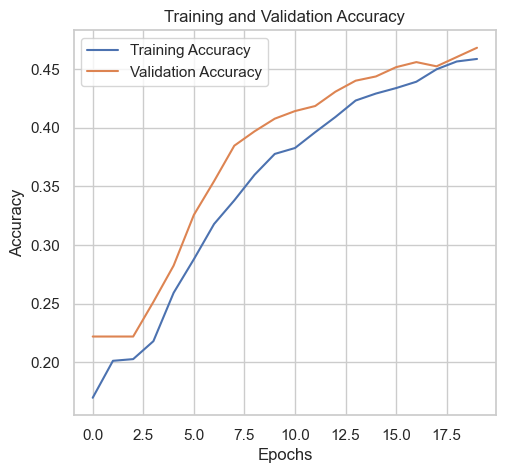

In [84]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bilstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Actor-Critic Methods

In [79]:
class BILSTMenvironment(gym.Env):
    def __init__(self, model_BILSTM, X_data):
        super(BILSTMenvironment, self).__init__()
        
        self.model_BILSTM = model_BILSTM
        self.X_data = X_data
        self.state = None
        
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(X_data.shape[1],), dtype=np.float32)
    
    def reset(self):
        random_index = np.random.randint(0, len(self.X_data))
        self.state = self.X_data[random_index]
        return self.state
    
    def step(self, action):
        random_index = np.random.randint(0, len(self.X_data))
        next_state = self.X_data[random_index]
        
        prediction = self.model_BILSTM.predict(np.expand_dims(self.state, axis=0))
        reward = self.calculate_reward(prediction, action)
        
        done = np.random.choice([True, False], p=[0.1, 0.9])
        info = {}
        
        self.state = next_state
        return self.state, reward, done, info
    
    def calculate_reward(self, prediction, action):
        if action == np.argmax(prediction):
            return 1
        else:
            return -0.1
    
    def render(self, mode='human'):
        pass
    
    def close(self):
        pass

In [80]:
env = BILSTMenvironment(model, X_train)

In [81]:
def build_actor(state_shape, action_space):
    state_input = Input(shape=state_shape)
    x = Dense(24, activation='relu')(state_input)
    x = Dense(24, activation='relu')(x)
    action_output = Dense(action_space, activation='softmax')(x)
    
    model = Model(inputs=state_input, outputs=action_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy')
    return model

In [82]:
def build_critic(state_shape):
    state_input = Input(shape=state_shape)
    x = Dense(24, activation='relu')(state_input)
    x = Dense(24, activation='relu')(x)
    value_output = Dense(1, activation='linear')(x)
    
    model = Model(inputs=state_input, outputs=value_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [91]:
class ActorCriticAgent:
    def __init__(self, actor_model, critic_model, env, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.actor_model = actor_model
        self.critic_model = critic_model
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.reward_per_episode_actor_critic_method = []  # Ubah nama variabel di sini
        self.epsilons = []
        self.critic_loss_fn = tf.keras.losses.MeanSquaredError()
        self.actor_optimizer = Adam(learning_rate=0.001)
        self.critic_optimizer = Adam(learning_rate=0.001)

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()  # Random action if under exploration
        policy = self.actor_model.predict(state, batch_size=1).flatten()
        policy = np.nan_to_num(policy)  # Replace NaN with zero
        policy_sum = np.sum(policy)
        if policy_sum == 0:
            policy = np.ones_like(policy) / len(policy)  # Uniform distribution if sum is zero
        else:
            policy /= policy_sum  # Normalize to make it a valid probability distribution
        return np.random.choice(len(policy), p=policy)

    def train(self, episodes=10, max_steps_per_episode=100):
        for episode in range(episodes):
            state = self.env.reset()
            state = np.expand_dims(state, axis=0)
            total_reward = 0
            steps = 0
            
            while True:
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.expand_dims(next_state, axis=0)
                
                target = reward + self.gamma * self.critic_model.predict(next_state)[0] * (1 - int(done))
                target_f = self.critic_model.predict(state)
                
                with tf.GradientTape() as tape:
                    critic_value = self.critic_model(state, training=True)
                    critic_loss = self.critic_loss_fn(target, critic_value)
                critic_grads = tape.gradient(critic_loss, self.critic_model.trainable_variables)
                self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic_model.trainable_variables))
                
                advantage = target - critic_value
                
                with tf.GradientTape() as tape:
                    action_probs = self.actor_model(state, training=True)
                    action_log_probs = tf.math.log(action_probs[0, action])
                    actor_loss = -advantage * action_log_probs
                actor_grads = tape.gradient(actor_loss, self.actor_model.trainable_variables)
                self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor_model.trainable_variables))
                
                state = next_state
                total_reward += reward
                steps += 1
                if done or steps >= max_steps_per_episode:
                    self.reward_per_episode_actor_critic_method.append(total_reward)  # Ubah referensi variabel di sini
                    self.epsilons.append(self.epsilon)
                    self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
                    print(f"Episode: {episode + 1}, Score: {total_reward}, Epsilon: {self.epsilon}, Steps: {steps}")
                    break

    def get_history(self):
        return self.reward_per_episode_actor_critic_method, self.epsilons

In [92]:
actor_model = build_actor((X_train.shape[1],), 2)
critic_model = build_critic((X_train.shape[1],))

In [93]:
agent = ActorCriticAgent(actor_model, critic_model, env)
agent.train(episodes=100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━

In [94]:
# Fungsi Visualisasi di luar class
def plot_rewards(rewards):
    plt.figure(figsize=(16, 8))
    plt.plot(rewards, marker='o', linestyle='-', color='b')
    plt.title('Reward Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()

def plot_epsilons(epsilons):
    plt.figure(figsize=(10, 5))
    plt.plot(epsilons, label='Epsilon per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay')
    plt.legend()
    plt.show()

In [95]:
reward_per_episode_actor_critic_method, epsilons = agent.get_history()

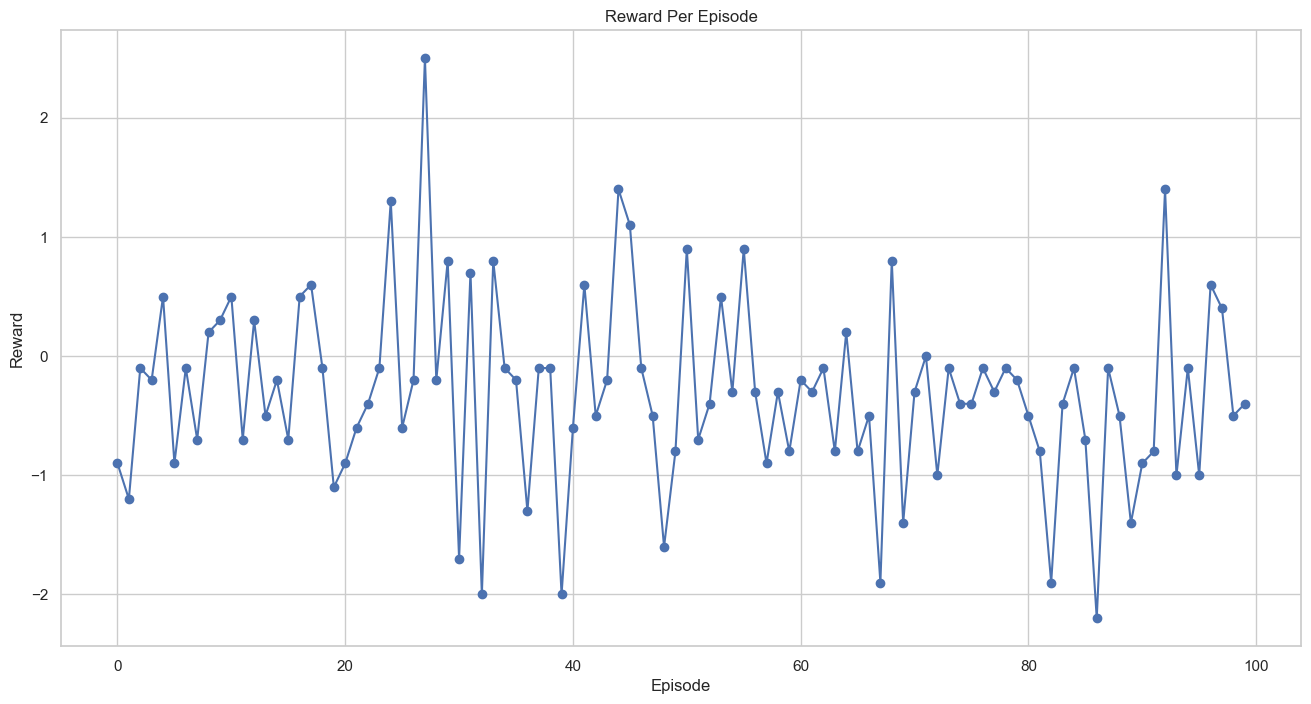

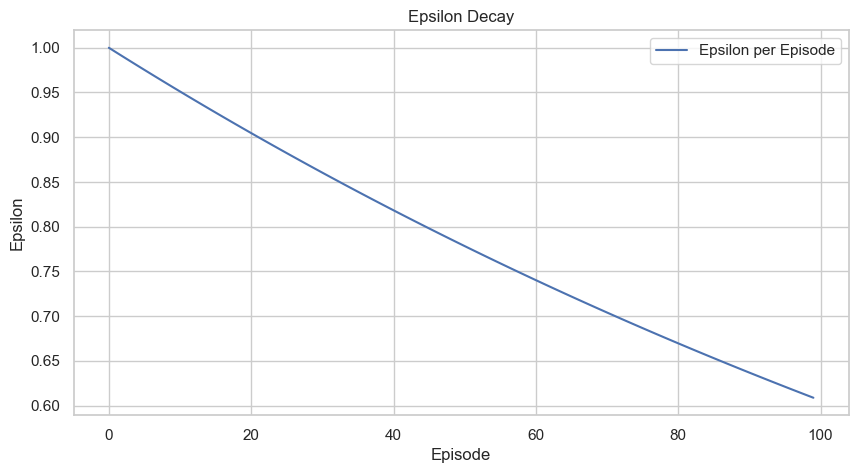

In [96]:
plot_rewards(reward_per_episode_actor_critic_method)
plot_epsilons(epsilons)

### 5. Model Transformer

In [85]:
def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, rate=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    
    return ffn_output

def build_transformer_model(vocab_size, max_len, embed_dim=32, num_heads=2, ff_dim=32):
    inputs = Input(shape=(max_len,))
    embedding_layer = Embedding(vocab_size, embed_dim)(inputs)
    x = transformer_encoder(embedding_layer, embed_dim, num_heads, ff_dim)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(16, activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

vocab_size = 5000 
max_len = 500

model = build_transformer_model(vocab_size, max_len)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_transformer = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 48s 252ms/step - accuracy: 0.1991 - loss: 2.3731 - val_accuracy: 0.2738 - val_loss: 2.1926
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 52s 299ms/step - accuracy: 0.3125 - loss: 2.1191 - val_accuracy: 0.3487 - val_loss: 2.0139
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 39s 221ms/step - accuracy: 0.4440 - loss: 1.7985 - val_accuracy: 0.4474 - val_loss: 1.8286
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 35s 204ms/step - accuracy: 0.5880 - loss: 1.4155 - val_accuracy: 0.4827 - val_loss: 1.7817
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 37s 212ms/step - accuracy: 0.6615 - loss: 1.1521 - val_accuracy: 0.4669 - val_loss: 1.8677
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 39s 224ms/step - accuracy: 0.7709 - loss: 0.8185 - val_accuracy: 0.4539 - val_loss: 2.1916
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 37s 215ms/step - accuracy: 0.8517 - loss: 0.5623 - val_accuracy: 0.4200 - val_loss: 2.6424
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 42s 241ms/step - accuracy: 0.9027 - loss: 0

In [86]:
# Evaluasi model
score, acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test score: {score}, Test accuracy: {acc}')

55/55 - 5s - 93ms/step - accuracy: 0.4282 - loss: 3.5352
Test score: 3.5352048873901367, Test accuracy: 0.4282420873641968


In [87]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step


In [88]:
conf_metrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_metrix)

Confusion Matrix:
[[  7   6   2   0   0   0   0   0  10   7   1   4   1   2   1   0]
 [  2  53   1   8   0   0   0   2  11  21  11  12   0   3   0   1]
 [  3   1  13   5   0   1   0   3   1   1   3   9   2   0   0   2]
 [  3  12   3  49   0   0   0   1  15   8   9  28   2   3   0   2]
 [  0   0   0   1   0   0   0   0   1   2   0   2   0   0   1   0]
 [  0   1   1   1   0   0   0   0   1   0   1   3   0   0   0   0]
 [  0   0   0   1   0   0   0   0   3   1   1   1   0   0   0   0]
 [  1   1   1   1   0   0   0   4   1   0   1   4   0   0   0   1]
 [ 10  12   4  19   2   1   0   1 112  57  23  30   8   7   0   2]
 [  6  17   1  14   2   1   0   3  49 215  13  38   3   4   1   3]
 [  0   7   9  10   0   0   0   1  23  25  72  33   4   3   3   3]
 [  2   9   6  14   2   0   0   0  16  29  26 175   4   3   1   6]
 [  1   1   2   1   2   0   0   2   6   9   1   7   8   1   2   2]
 [  0   0   1   3   1   1   0   2   6  18   2   6   3   9   1   0]
 [  2   4   1   2   0   0   0   3   2   4   

In [89]:
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(16)], zero_division=0)
print("classification_report")
print(report)

classification_report
              precision    recall  f1-score   support

     Class 0       0.19      0.17      0.18        41
     Class 1       0.41      0.42      0.42       125
     Class 2       0.27      0.30      0.28        44
     Class 3       0.36      0.36      0.36       135
     Class 4       0.00      0.00      0.00         7
     Class 5       0.00      0.00      0.00         8
     Class 6       0.00      0.00      0.00         7
     Class 7       0.17      0.27      0.21        15
     Class 8       0.43      0.39      0.41       288
     Class 9       0.53      0.58      0.55       370
    Class 10       0.42      0.37      0.40       193
    Class 11       0.47      0.60      0.53       293
    Class 12       0.21      0.18      0.19        45
    Class 13       0.24      0.17      0.20        53
    Class 14       0.52      0.25      0.34        44
    Class 15       0.38      0.22      0.28        67

    accuracy                           0.43      1735
   m

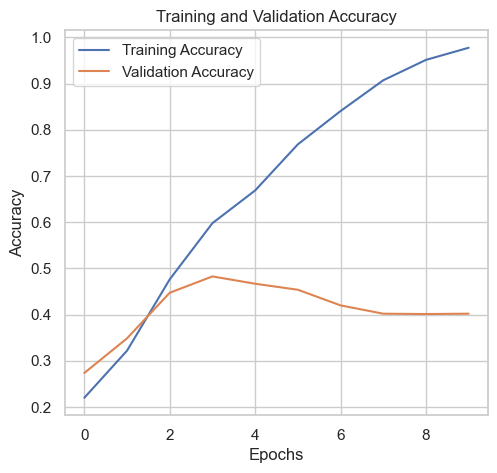

In [90]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_transformer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transformer.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

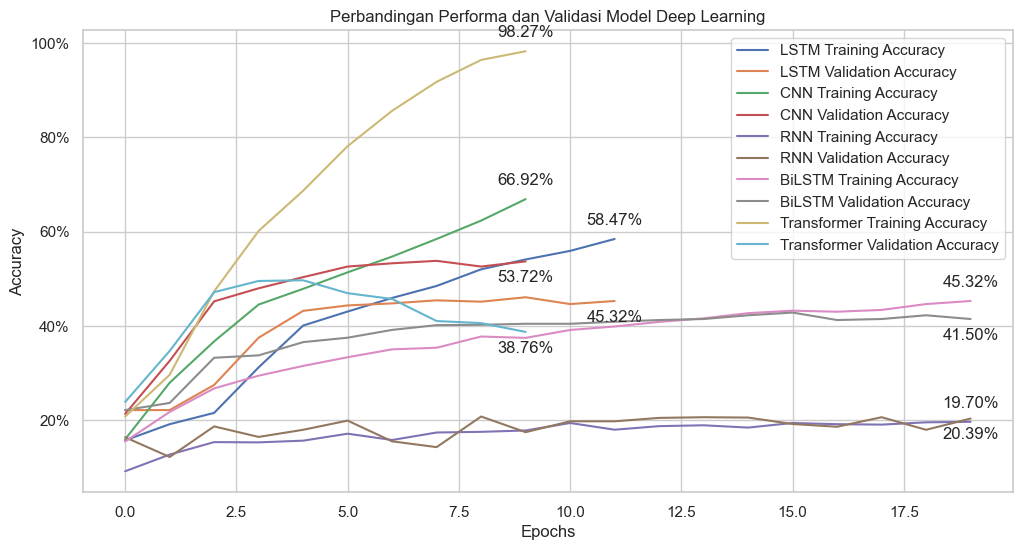

In [50]:
plt.figure(figsize=(12, 6))

# Plot LSTM history
plt.plot(history_lstm.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.annotate(f"{history_lstm.history['accuracy'][-1]:.2%}", (len(history_lstm.history['accuracy'])-1, history_lstm.history['accuracy'][-1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f"{history_lstm.history['val_accuracy'][-1]:.2%}", (len(history_lstm.history['val_accuracy'])-1, history_lstm.history['val_accuracy'][-1]), textcoords="offset points", xytext=(0,-15), ha='center')

# Plot CNN history
plt.plot(history_cnn.history['accuracy'], label='CNN Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation Accuracy')
plt.annotate(f"{history_cnn.history['accuracy'][-1]:.2%}", (len(history_cnn.history['accuracy'])-1, history_cnn.history['accuracy'][-1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f"{history_cnn.history['val_accuracy'][-1]:.2%}", (len(history_cnn.history['val_accuracy'])-1, history_cnn.history['val_accuracy'][-1]), textcoords="offset points", xytext=(0,-15), ha='center')

# Plot RNN history
plt.plot(history_rnn.history['accuracy'], label='RNN Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Validation Accuracy')
plt.annotate(f"{history_rnn.history['accuracy'][-1]:.2%}", (len(history_rnn.history['accuracy'])-1, history_rnn.history['accuracy'][-1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f"{history_rnn.history['val_accuracy'][-1]:.2%}", (len(history_rnn.history['val_accuracy'])-1, history_rnn.history['val_accuracy'][-1]), textcoords="offset points", xytext=(0,-15), ha='center')

# Plot BiLSTM history
plt.plot(history_bilstm.history['accuracy'], label='BiLSTM Training Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='BiLSTM Validation Accuracy')
plt.annotate(f"{history_bilstm.history['accuracy'][-1]:.2%}", (len(history_bilstm.history['accuracy'])-1, history_bilstm.history['accuracy'][-1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f"{history_bilstm.history['val_accuracy'][-1]:.2%}", (len(history_bilstm.history['val_accuracy'])-1, history_bilstm.history['val_accuracy'][-1]), textcoords="offset points", xytext=(0,-15), ha='center')

# Plot Transformer history
plt.plot(history_transformer.history['accuracy'], label='Transformer Training Accuracy')
plt.plot(history_transformer.history['val_accuracy'], label='Transformer Validation Accuracy')
plt.annotate(f"{history_transformer.history['accuracy'][-1]:.2%}", (len(history_transformer.history['accuracy'])-1, history_transformer.history['accuracy'][-1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f"{history_transformer.history['val_accuracy'][-1]:.2%}", (len(history_transformer.history['val_accuracy'])-1, history_transformer.history['val_accuracy'][-1]), textcoords="offset points", xytext=(0,-15), ha='center')

plt.title('Perbandingan Performa dan Validasi Model Deep Learning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.legend()
plt.show()

### Proximal Policy Optimization (PPO)

In [98]:
# Definisikan lingkungan custom
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        self.observation_space = spaces.Box(low=0, high=4999, shape=(500,), dtype=np.int32)
        self.action_space = spaces.Discrete(16)
        self.state = np.zeros((500,), dtype=np.int32)
        self.episode_length = 100
        self.current_step = 0

    def reset(self):
        self.state = np.zeros((500,), dtype=np.int32)
        self.current_step = 0
        return self.state

    def step(self, action):
        self.current_step += 1
        self.state = np.random.randint(0, 5000, size=(500,), dtype=np.int32)
        reward = np.random.random()  # Placeholder reward logic
        done = self.current_step >= self.episode_length
        return self.state, reward, done, {}

    def render(self, mode='human'):
        pass


In [99]:
env = CustomEnv()

In [100]:
# Definisikan policy transformer
class TransformerPolicy(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, embed_dim=32, num_heads=2, ff_dim=32):
        super(TransformerPolicy, self).__init__(observation_space, features_dim=embed_dim)
        self.embedding = nn.Embedding(5000, embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, observations: th.Tensor) -> th.Tensor:
        observations = observations.long() 
        x = self.embedding(observations)
        x = x.permute(1, 0, 2) 
        attn_output, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + attn_output)
        ffn_output = self.ffn(x)
        x = self.layer_norm2(x + ffn_output)
        x = x.permute(1, 2, 0)
        x = self.global_pool(x)
        return x.squeeze(-1)

In [101]:
# Definisikan dan bungkus lingkungan custom dengan DummyVecEnv
env = DummyVecEnv([lambda: CustomEnv()])

e:\python\ARTIFICIAL INTELEGENT\NLP\PENELITIAN MBTI\env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [102]:
# Definisikan callback untuk menyimpan reward
class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []

    def _on_step(self) -> bool:
        # Simpan reward saat episode selesai
        if self.locals['dones']:
            self.episode_rewards.append(self.locals['rewards'][0])
        return True

In [103]:
# Inisialisasi callback
reward_callback = RewardCallback()

In [104]:
# Definisikan policy network
policy_kwargs = dict(
    features_extractor_class=TransformerPolicy,
    features_extractor_kwargs=dict(embed_dim=32, num_heads=2, ff_dim=32),
    net_arch=[dict(pi=[64, 64], vf=[64, 64])]
)

In [105]:
# Buat agen PPO
model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1)

Using cpu device


e:\python\ARTIFICIAL INTELEGENT\NLP\PENELITIAN MBTI\env\lib\site-packages\stable_baselines3\common\policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
e:\python\ARTIFICIAL INTELEGENT\NLP\PENELITIAN MBTI\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [116]:
# Melatih agen PPO dengan total_timesteps sebesar 100 dan menggunakan callback untuk menyimpan reward
model.learn(total_timesteps=1000, callback=reward_callback)

-----------------------------
| time/              |      |
|    fps             | 134  |
|    iterations      | 1    |
|    time_elapsed    | 15   |
|    total_timesteps | 2048 |
-----------------------------


In [117]:
# Simpan reward untuk visualisasi nanti
rewards_per_episode_Proximal_Policy_Optimization= reward_callback.episode_rewards

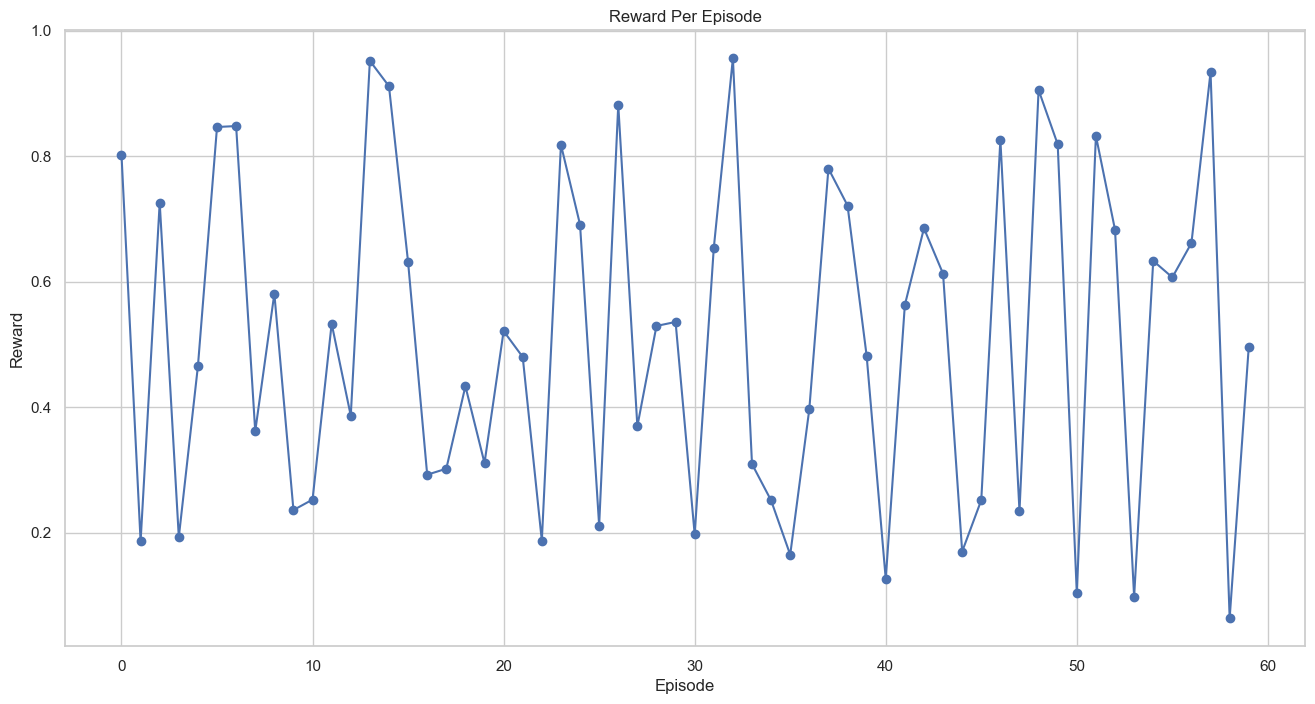

In [118]:
# Visualisasikan reward menggunakan Matplotlib
plt.figure(figsize=(16, 8))
plt.plot(rewards_per_episode_Proximal_Policy_Optimization, marker='o', linestyle='-', color='b')
plt.title('Reward Per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

Mengidentifikasi Episode dalam Pelatihan Agen PPO
Jumlah episode yang dieksekusi selama pelatihan tidak ditentukan langsung oleh total_timesteps, melainkan tergantung pada panjang episode dalam lingkungan. Berikut adalah penjelasan singkat bagaimana episode dihitung dalam pelatihan:

Episode: Satu episode dimulai dari panggilan reset() pada lingkungan hingga lingkungan mengembalikan done=True dalam metode step().
Timestep: Satu timestep adalah satu interaksi antara agen dan lingkungan, yaitu satu panggilan ke step().
Pelatihan akan berjalan untuk total_timesteps langkah waktu. Jumlah episode yang akan dilalui bergantung pada panjang setiap episode yang diatur dalam lingkungan.

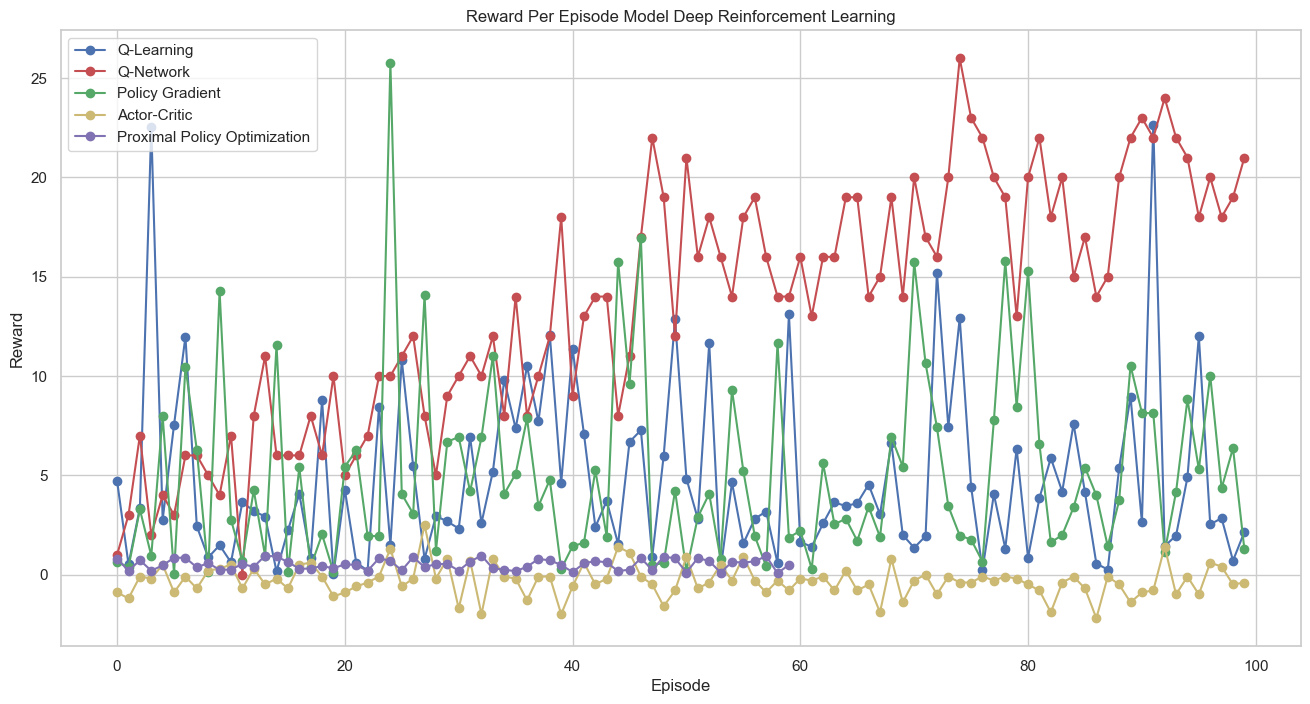

In [120]:
# Membuat plot
plt.figure(figsize=(16, 8))
plt.plot(rewards_per_episode_Q_learning, marker='o', linestyle='-', color='b', label='Q-Learning')
plt.plot(rewards_per_episode_Q_nertwork, marker='o', linestyle='-', color='r', label='Q-Network')
plt.plot(rewards_per_episode_policy_gradient_methode, marker='o', linestyle='-', color='g', label='Policy Gradient')
plt.plot(reward_per_episode_actor_critic_method, marker='o', linestyle='-', color='y', label='Actor-Critic')
plt.plot(rewards_per_episode_Proximal_Policy_Optimization, marker='o', linestyle='-', color='m', label='Proximal Policy Optimization')

# Menambahkan judul dan label
plt.title('Reward Per Episode Model Deep Reinforcement Learning')
plt.xlabel('Episode')
plt.ylabel('Reward')

# Menampilkan grid dan legenda
plt.grid(True)
plt.legend()

# Menampilkan plot
plt.show()